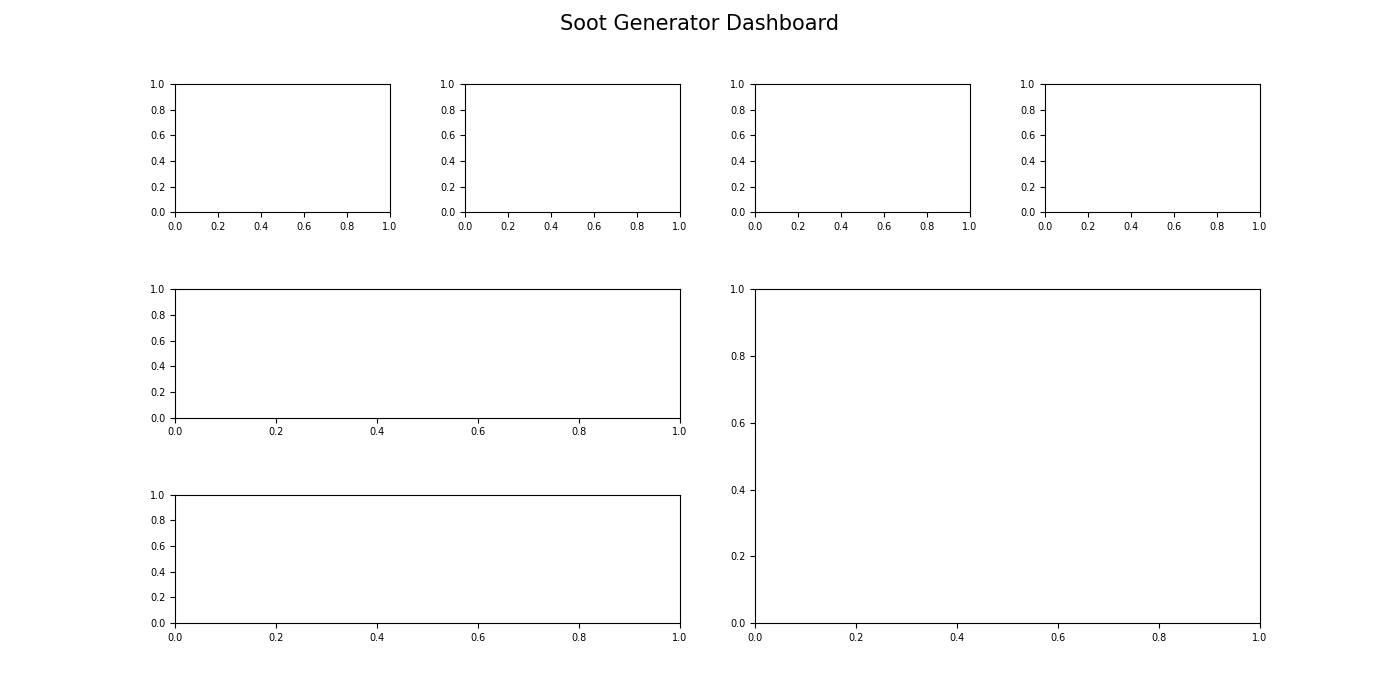

In [1]:
%matplotlib ipympl
#%matplotlib inline

#import libraries and functions
import pandas as pd
import ipywidgets, asyncio, time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.style as mplstyle
mpl.rcParams['path.simplify_threshold'] = 1.0
mplstyle.use('fast')
import AlicatMFC as alicat

itemLayout = ipywidgets.Layout(width = "auto",height = "30px")
def colLayout(wid):
    return ipywidgets.Layout(display = "flex",flex_flow='column',border = '1px solid black',align_items = "stretch",justify_content="flex-start",width = wid)

#create widgets
running = ipywidgets.ToggleButton(description="start", icon="play",button_style = 'danger', layout = itemLayout)
propaneSetpoint = ipywidgets.FloatSlider(description = "Prop",value = 0, min = 0, max = 0.1, step = 0.005, layout = itemLayout)
airSetpoint = ipywidgets.FloatSlider(description = "Air",value = 0, min = 0, max = 10, step = 0.1, layout = itemLayout)
xlim = ipywidgets.IntSlider(description="xlim", value=50, min=10, max=1000, layout = itemLayout)

timeBase = ipywidgets.FloatText(description = "Timebase", layout = itemLayout)
ewmNum = ipywidgets.IntText(description="EWM COM",value = 15, layout = itemLayout)
tapePosition = ipywidgets.FloatText(description = "Tape Position", layout = itemLayout)
flowSetpoint = ipywidgets.FloatText(description = "Flow Setpoint", layout = itemLayout)

manualOverride = ipywidgets.Checkbox(value=True,description = "Manual Override", layout = itemLayout,indent = False)
manualPulse = ipywidgets.Checkbox(value = False, description = "pulse?", layout = itemLayout,indent = False)
manualPulseTime = ipywidgets.FloatText(value = 0.5, step = 0.05,layout = ipywidgets.Layout(width ="50px" ))
manualPulseBox = ipywidgets.HBox(children = [manualPulseTime,manualPulse],layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))
onPulse = ipywidgets.FloatText(description = "on pulse",value = 0.5, layout = itemLayout)
offPulse = ipywidgets.FloatText(description = "off pulse",value = 5, layout = itemLayout)
pulsingStatus = ipywidgets.Textarea()
flushing = ipywidgets.Checkbox(value = False, description = "flushing?", layout = itemLayout,indent = False,disabled = True)

plotTime = ipywidgets.Textarea(description="plot time", layout = itemLayout)
totalTime = ipywidgets.Textarea(description="run time", layout = itemLayout)
elapsedTime = ipywidgets.Textarea(description="interval", layout = itemLayout)
interval = ipywidgets.FloatSlider(description="loop interval", value=1, min=0.001, max=3, layout = itemLayout) # zero can hang if you don't await
currentData = ipywidgets.Textarea(description="data", layout = itemLayout)

IRBc1 = ipywidgets.FloatText(description="IR Bc1", layout = itemLayout)
Bc1EWM = ipywidgets.FloatText(description="EWM Bc1", layout = itemLayout)
IRBcc = ipywidgets.FloatText(description="IR Bcc", layout = itemLayout)
BccEWM = ipywidgets.FloatText(description="EWM Bcc", layout = itemLayout)

#create widget layout
col1 = ipywidgets.VBox(children = [running,propaneSetpoint,airSetpoint,xlim],layout = colLayout("20%"))
col2 = ipywidgets.VBox(children = [timeBase,ewmNum,tapePosition,flowSetpoint],layout = colLayout("15%"))
col3 = ipywidgets.VBox(children = [manualOverride,manualPulseBox,onPulse,offPulse,flushing],layout = colLayout("15%"))
col4 = ipywidgets.VBox(children = [IRBc1,Bc1EWM,IRBcc,BccEWM],layout = colLayout("15%"))
col5 = ipywidgets.VBox(children = [plotTime,totalTime,elapsedTime,interval,currentData],layout = colLayout("20%"))
ui = ipywidgets.HBox([col1,col2,col3,col4,col5],layout=ipywidgets.Layout(width = "1400px"))

tasks = dict()

#create panda dataframes
dfAeth =  pd.DataFrame([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],columns=['timebase', 'tape position', 'flow setpoint', 'flow total', 'sample temp', 'sample rh', 'sample dewpoint', 'uv atn1', 'uv atn2', 'ir atn1', 'ir atn2', 'ir bc1', 'ir bcc',"bc1 ewm","bcc ewm"])
dfMFC1 = pd.DataFrame(columns=['pressure','temperature','volumetric_flow','mass_flow','setpoint'])       
dfMFC2 = pd.DataFrame(columns=['pressure','temperature','volumetric_flow','mass_flow','setpoint']) 
dfSolenoid = pd.DataFrame(columns = ["timestamp","pulse duration","save status"])
dfImportant = pd.DataFrame(columns = ["timestamp", "runtime","air pressure","air temperature","propane pressure", "propane temperature","air setpoint","propane setpoint", "air mass flow","propane mass flow","sample temp","ir bc1","ir bcc","bc1 ewm","bcc ewm"])

#measure runtime and elapsed time per loop
times = [time.time()]
startTime = time.time()

pulsing = False

async def update_plots(t,recent):
    
    #get flow controller data
    alicatArray1 = alicat.getMFCData(1)
    alicatData1 = [alicatArray1]
    alicatArray2 = alicat.getMFCData(2)
    alicatData2 = [alicatArray2]

    #create and concat new MFC data into panda dataframes
    dfNewMFC1 = pd.DataFrame(alicatData1,columns=['pressure','temperature','volumetric_flow','mass_flow','setpoint'])
    dfNewMFC2 = pd.DataFrame(alicatData2,columns=['pressure','temperature','volumetric_flow','mass_flow','setpoint'])
    global dfMFC1
    dfMFC1 = pd.concat([dfMFC1,dfNewMFC1],ignore_index=True)
    global dfMFC2
    dfMFC2 = pd.concat([dfMFC2,dfNewMFC2],ignore_index=True)

    #get aeth data, and account for the possibility that it will get a 0
    aethData = alicat.getMicroAethData()
    
    if (len(aethData) != 13):
        aethData = recent
    else:
        aethData = aethData + [0,0]

    #display raw data from MA350
    currentData.value = ', '.join(str(val) for val in aethData)
    
    #concatenate the new data to the original dataframe
    aethData = [aethData]
    dfNewAeth = pd.DataFrame(aethData, columns=['timebase', 'tape position', 'flow setpoint', 'flow total', 'sample temp', 'sample rh', 'sample dewpoint', 'uv atn1', 'uv atn2', 'ir atn1', 'ir atn2', 'ir bc1', 'ir bcc',"bc1 ewm","bcc ewm"])
    global dfAeth
    dfAeth = pd.concat([dfAeth,dfNewAeth],ignore_index = True)
    
    #get exponentially weighted means and add to dataframe
    index = len(dfMFC1["setpoint"])-1
    dfAeth["bc1 ewm"] = dfAeth["ir bc1"].ewm(com = ewmNum.value).mean()
    dfAeth["bcc ewm"] = dfAeth["ir bcc"].ewm(com = ewmNum.value).mean()
    
    for ax in axes:
        axes[ax].clear()
        axes[ax].set_xlim(index+1-xlim.value,index+1)
    
    #update each plot
    axes["A"].plot(dfMFC2["pressure"], label = "Pressure (PSIA)",color = "red")
    axes["A"].plot(dfMFC2["temperature"], label = "Temperature (C)",color = "orange")
    
    axes["B"].plot(dfMFC1["pressure"], label = "Pressure (PSIA)",color = "red")
    axes["B"].plot(dfMFC1["temperature"], label = "Temperature (C)",color = "orange")
        
    axes["C"].plot(dfAeth["sample rh"], label = "RH", color = "orange")
    axes["C"].plot(dfAeth["sample temp"], label = "Temp", color = "red")
    axes["C"].plot(dfAeth["sample dewpoint"], label = "Dewpoint", color = "blue")

    axes["D"].plot(dfAeth["uv atn1"], label = "UV ATN1", color = "pink")
    axes["D"].plot(dfAeth["uv atn2"], label = "UV ATN2", color = "red")
    axes["D"].plot(dfAeth["ir atn1"], label = "IR ATN1", color = "orange")
    axes["D"].plot(dfAeth["ir atn2"], label = "IR ATN2", color = "yellow")
    
    axes["E"].plot(dfMFC2["setpoint"], label = "Setpoint (SLPM)", color = "blue")
    axes["E"].plot(dfMFC2["mass_flow"], label = "Mass Flow Rate (SLPM)", color = "black")
    
    axes["F"].plot(dfMFC1["setpoint"], label = "Setpoint (SLPM)", color = "blue")
    axes["F"].plot(dfMFC1["mass_flow"], label = "Mass Flow Rate (SLPM)", color = "black")
    
    axes["G"].plot(dfAeth["ir bc1"], label = "IR BC1", color = "navy")
    axes["G"].plot(dfAeth["ir bcc"], label = "IR BCC", color = "purple")
    axes["G"].plot(dfAeth["bc1 ewm"], label = "BC1 EWM", color = "cyan")
    axes["G"].plot(dfAeth["bcc ewm"], label = "BCC EWM", color = "magenta")
    
    axes["A"].set_title("Propane MFC")
    axes["B"].set_title("Air MFC")
    axes["C"].set_title("MA350 Miscellaneous")
    axes["D"].set_title("MA350 Attenuations")
    axes["E"].set_title("Propane flow")
    axes["F"].set_title("Air Flow")
    axes["G"].set_title("IR BCC Values")

    for ax in axes:
        axes[ax].legend(loc = "upper left")
    
    startPlot = time.time()
    fig.canvas.draw()
    fig.canvas.flush_events()
    plotTime.value = str(round(time.time()-startPlot,4))

    #update time widgets
    times.append(time.time())
    elapsedTime.value = f"{t}: {round(times[-1]-times[-2],4)}"
    totalTime.value = str(round(time.time() - startTime,4))
    
    #update numerical black carbon widgets
    IRBcc.value = dfAeth.iat[index,12]
    IRBc1.value = dfAeth.iat[index,11]
    BccEWM.value = round(dfAeth.iat[index,14],4)
    Bc1EWM.value = round(dfAeth.iat[index,13],4)
    timeBase.value = dfAeth.iat[index,0]
    tapePosition.value = dfAeth.iat[index,1]
    flowSetpoint.value = dfAeth.iat[index,2]
                           
    #update DF for saving
    global dfImportant 
    dfImportant = pd.concat([dfImportant,pd.DataFrame({"timestamp": time.time(),
                       "runtime": time.time()-startTime,
                       "air pressure":alicatArray1[0],
                       "air temperature":alicatArray1[1],
                       "propane pressure":alicatArray2[0],
                       "propane temperature":alicatArray2[1],
                       "air setpoint":alicatArray1[4],
                       "propane setpoint":alicatArray2[4], 
                       "air mass flow":alicatArray1[3],
                       "propane mass flow":alicatArray2[3],
                       "sample temp":aethData[0][4],
                       "ir bc1":dfNewAeth["ir bc1"],
                       "ir bcc":dfNewAeth["ir bcc"],
                       "bc1 ewm":dfAeth.at[len(dfAeth)-1,"bc1 ewm"],
                       "bcc ewm":dfAeth.at[len(dfAeth)-1,"bcc ewm"]
                       },index = [0])],ignore_index = True)
                           
async def update_setpoints():
    alicat.setSetPoint(1,airSetpoint.value)
    alicat.setSetPoint(2,propaneSetpoint.value)
    
async def control_solenoid():
    #control solenoid via tcp connection
    if manualOverride.value == True:
        pulsingStatus.value = "manual"
            
        #tell program that it has stopped pulsing
        alicat.sendTCP("stop pulsing")
        
        if manualPulse.value == True:
            
            #pulse for x time, format is 1open0.5 where 0.5 is the manual pulse direction, then turn the manualPulse value off so it only runs once
            alicat.sendTCP(f"1open{manualPulseTime.value}")
            #dfSolenoid.append({"timestamp":round(time.time(),6),"pulse duration":manualPulseTime.value,"save status":False},ignore_index = True)
            global dfSolenoid
            dfSolenoid = pd.concat([dfSolenoid,pd.DataFrame({"timestamp":round(time.time(),6),"pulse duration":manualPulseTime.value,"save status":False},index = [0])],ignore_index = True)
            manualPulse.value = False
            
            if flushing.value == True:
                flushing.value = False
                dt_string = datetime.now().strftime("%d-%m-%Y %H-%M-%S")
                df_runtime = round(float(totalTime.value),2)
                flush_duration = round(dfSolenoid.at[dfSolenoid.shape[0]-1,"timestamp"] - dfSolenoid.at[dfSolenoid.shape[0]-2,"timestamp"], 2)
                dfSave = dfImportant[-int(flush_duration):].reset_index()
                starting_ewm = round(dfSave.at[0,"bcc ewm"],2)
                starting_sample_temp = round(dfSave.at[0,"sample temp"],3)
                low = round(dfSave["bcc ewm"].min(),5)
                air_setpoint = round(dfSave["propane setpoint"].mean(),2)
                propane_setpoint = round(dfSave["air setpoint"].mean(),2)
                dfSave.to_pickle(f"C:\\Users\\Kyan Shlipak\\Documents\\Solenoid Pulse DataFrames\\ Flush {dt_string} {df_runtime} {flush_duration} {starting_sample_temp} {starting_ewm} {low} {air_setpoint} {propane_setpoint}.pkl")
                
        #check if dataframe needs to be saved                   
        for index,row in dfSolenoid.iterrows():
            
            #save if it hasn't been saved and enough time has passed
            if (row["save status"] == False) and ((time.time() -row["timestamp"]) > 300):
                dt_string = datetime.now().strftime("%d-%m-%Y %H-%M-%S")
                dfSave = dfImportant[-300:].reset_index()
                df_runtime = round(float(totalTime.value),2)
                pulse_duration = dfSolenoid.at[dfSolenoid.shape[0]-1,"pulse duration"]
                starting_ewm = round(dfSave.at[0,"bcc ewm"],2)
                starting_sample_temp = round(dfSave.at[0,"sample temp"],3)
                peak = round(dfSave["bcc ewm"].max(),5)
                air_setpoint = round(dfSave["propane setpoint"].mean(),2)
                propane_setpoint = round(dfSave["air setpoint"].mean(),2)
                dfSave.to_pickle(f"C:\\Users\\Kyan Shlipak\\Documents\\Solenoid Pulse DataFrames\\ Pulse {dt_string} {df_runtime} {pulse_duration} {starting_sample_temp} {starting_ewm} {peak} {air_setpoint} {propane_setpoint}.pkl")
                dfSolenoid.at[index,"save status"] = True
                
        #check if flushing
        try:
            if dfSolenoid.at[dfSolenoid.shape[0]-1,"save status"] == True:
                flushing.value = True
        except KeyError:
            pass
            #empty dataframe
                           
    elif manualOverride.value == False:
        pulsingStatus.value = "not manual"
        #start pulsing for x time on and y time off, format is 1openx,y. If already pulsing, the command will be ignored
        alicat.sendTCP(f"1pulse{onPulse.value},{offPulse.value}")        
    
async def do_loop():
    t = 0
    while running.value:
        recent = dfAeth.iloc[-1].tolist()
        asyncio.get_event_loop().create_task(update_plots(t,recent))
        asyncio.get_event_loop().create_task(update_setpoints())
        asyncio.get_event_loop().create_task(control_solenoid())
        t += 1
        await asyncio.sleep(0.993)

#stop or start main loop according to the start/stop button
def on_running_changed(*change):
    task = tasks.pop("do_loop", None)
    elapsedTime.value = f"maybe stopping {task}..."
   
    if task:
        task.cancel()
        alicat.closePorts()
        alicat.endTCP()

    if running.value:
        elapsedTime.value = "starting..."
        alicat.openPorts("COM3","COM4","COM5")
        try:
            alicat.endTCP()
        except NameError:
            pass
        time.sleep(0.1)
        alicat.startTCP()
        tasks["do_loop"] = asyncio.get_event_loop().create_task(do_loop())

#customize plot font sizes
plt.rc('axes',titlesize=10)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize = 8)
plt.rc('figure',titlesize = 15)
plt.rcParams['lines.linewidth'] = 1

#create "mosaic" customizing grid layout. Semicolons separate rows
fig,axes = plt.subplot_mosaic("ABCD;EEGG;FFGG")
fig.set_size_inches(14,7)
fig.suptitle("Soot Generator Dashboard")
plt.tight_layout
plt.subplots_adjust(wspace =0.35,hspace = 0.6)
plt.ion()
fig.canvas.draw()

#observe stop/start button
running.observe(on_running_changed, "value")

#display UI (widget grid)
ui

In [2]:
alicat.sendTCP("hefueh")

NameError: name 'client_socket' is not defined

In [ ]:
import time
from datetime import datetime
import pandas as pd
df  = pd.DataFrame({'a':[3,2,4,3,2,4,10],'b':[3,2,4,3,2,4,0]})


In [ ]:
dfSave = dfImportant[-100:].reset_index()
dfSave.head

In [ ]:
dfSolenoid

In [ ]:
dfSolenoid